# Counterfactuals

In [1]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(ggridges)
library(sdazar)
library(data.table)
library(MASS)
library(stringr)

# library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

Warning message:
“package ‘rstan’ was built under R version 3.4.3”Loading required package: ggplot2
Loading required package: StanHeaders
Warning message:
“package ‘StanHeaders’ was built under R version 3.4.3”rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Warning message:
“package ‘brms’ was built under R version 3.4.3”Loading required package: Rcpp
Warning message:
“package ‘Rcpp’ was built under R version 3.4.3”Loading 'brms' package (version 2.1.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
This is loo version 1.1.0
Loading required package: data.table
Warning message:
“package ‘data.table’

In [2]:
# load data
df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)] # remove rows with missing data

df[, le_log := scale(log(le), scale=FALSE)]
df[, gdp_log := scale(log(gdp), scale=FALSE)]
df[, year_log := scale(log(year), scale=FALSE)]

In [3]:
# year recode based on the criteria proposed by Alberto
df[year<1950, gyear:=1]
df[year>=1950 & year<1970, gyear:=2]
df[year>=1970 & year<1990, gyear:=3]
df[year>=1990, gyear :=4]
df[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]
df[, ctry := factor(ctry)]

In [4]:
table(df$gyear, useNA='ifany') # discrete groups of year


     1950 1950-1969 1970-1989      1990 
      103        76        76        88 

In [5]:
# transform variable: weibull
df[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
df[, wy := log(-log(1-y))]
max_le = df[, .(max_le = max(le+1.05)), by = ctry]

In [6]:
# function
get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

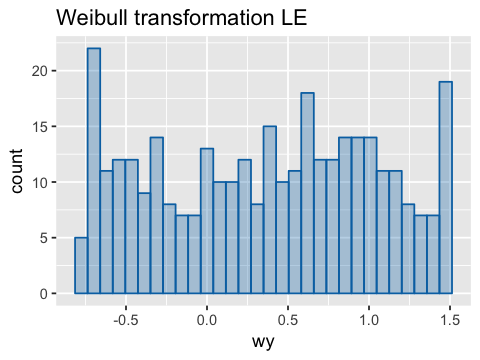

In [7]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

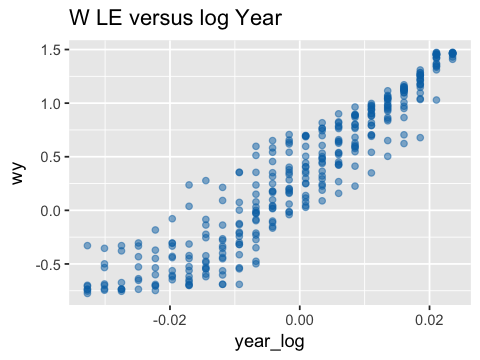

In [8]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(y=wy, x=year_log)) + geom_point(alpha=0.5, color='#0072B2') +
    labs(title='W LE versus log Year')

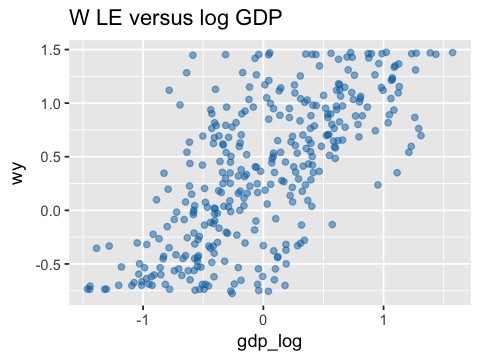

In [9]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.5, color='#0072B2') +
    labs(title='W LE versus log GDP')

### Counterfactuals

- I create a variable resulting from the combination of country and year
- I specify country-year random intercept and GDP random coefficient

In [10]:
# check sample sizes
df[, ctry_year := interaction(ctry, gyear)]
# table(df$ctry_year)

In [11]:
w1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = df, control=list(adapt_delta=0.85))

Compiling the C++ model
Start sampling


In [12]:
summary(w1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.47      0.04     0.39     0.56       1076 1.00
sd(gdp_log)                0.25      0.08     0.08     0.42        514 1.02
cor(Intercept,gdp_log)     0.02      0.26    -0.48     0.56       2846 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.41      0.06     0.29     0.52        732 1.00
gdp_log       0.74      0.07     0.62     0.88       1976 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.15      0.01    

### Examine GOF

In [13]:
pred = cbind(df[, .(ctry, year, le, year_log, gdp_log, le_log)], predict(w1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [14]:
max_value_le = max_le[ctry==2020, max_le]

In [15]:
pred = merge(pred, max_le, by = 'ctry')
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

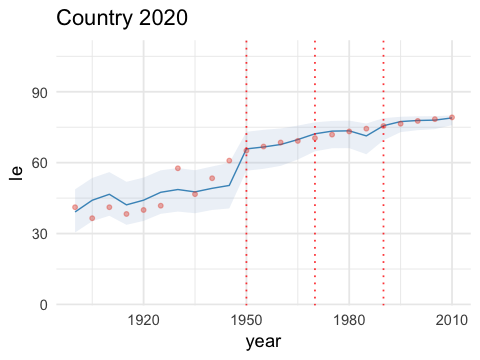

In [16]:
ggplot(pred[ctry==2020], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=1, color='#e34a33', alpha=0.4) +
    labs(title=paste0('Country ', '2020')) + 
        ylim(min(df$le)-25.0, max(df$le)+25.0) + 
        xlim(min(df$year), max(df$year)) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted') 

### Counterfactuals 2020

In [17]:
# extract posterior samples of population-level effects 
samples <- posterior_samples(w1)

In [18]:
years = c(1950, 1970, 1990, 2010)

gdp_values = df[ctry==2020 & year %in% years, gdp_log]
le_values = df[ctry==2020 & year %in% years, le]

In [19]:
# function to estimate shifts
estimate_shift = function(samples, country=NULL, 
                          model_year=NULL,
                          le_value=NULL,
                          gdp_value = NULL, 
                          max_le_value = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {

    colnames = names(samples)
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))
    s = samples[, c(betas, random)]
    pp = s[,1] + s[,3] + (s[,2] + s[,4]) * gdp_value
    pg = unlist(sapply(pred, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
        
     return(le_value-pg)
}

In [62]:
pred = list()
lyears = c('1950', '1950-1969', '1970-1989', '1990')

for (i in lyears) {

    pred[[i]] = estimate_shift(samples, country='2020',
                         model_year=i,
                         gdp_value = gdp_values[1],
                         le_value = le_values[1],
                         max_le_value=max_le[ctry==2020, max_le])
    
}

In [63]:
d = melt(data.frame(pred))

No id variables; using all as measure variables


In [142]:
l = unique(d$variable)
year_labels = c('<1950', '1950-1969', '1970-1989', '>=1990')
d$variable = factor(d$variable, levels=rev(l), labels=rev(year_labels))

Picking joint bandwidth of 0.401


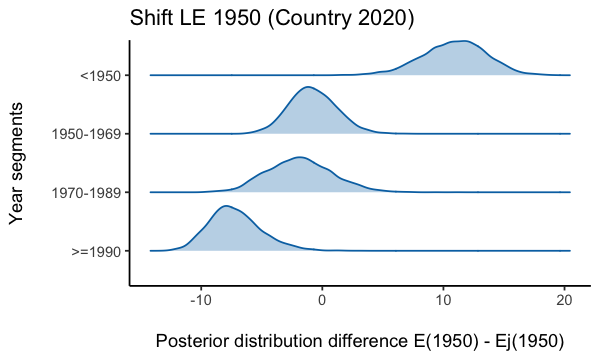

In [143]:
p = ggplot(d, aes(y=variable)) +
      geom_density_ridges(aes(x = value),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1950) - Ej(1950)', 
          y='Year segments\n', title='Shift LE 1950 (Country 2020)') + 
      theme_classic()
print(p)

### Counterfactuals 2070

In [164]:
pred = cbind(df[, .(ctry, year, le, year_log, gdp_log, le_log)], predict(w1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [165]:
max_value_le = max_le[ctry==2070, max_le]

In [166]:
pred = merge(pred, max_le, by = 'ctry')
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

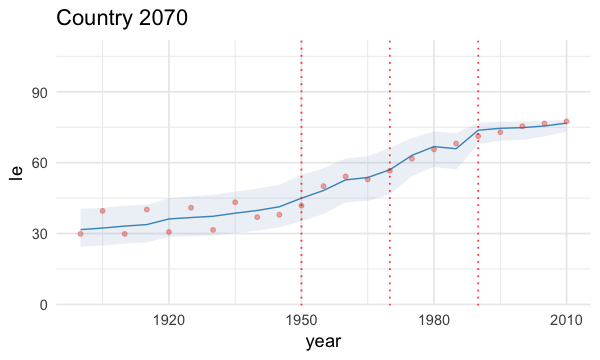

In [167]:
ggplot(pred[ctry==2070], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=1, color='#e34a33', alpha=0.4) +
    labs(title=paste0('Country ', '2070')) + 
        ylim(min(df$le)-25.0, max(df$le)+25.0) + 
        xlim(min(df$year), max(df$year)) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted') 

In [168]:
pred = list()
lyears = c('1950', '1950-1969', '1970-1989', '1990')

for (i in lyears) {

    pred[[i]] = estimate_shift(samples, country=2070,
                         model_year=i,
                         gdp_value = gdp_values[1],
                         le_value = le_values[1],
                         max_le_value=max_le[ctry==2070, max_le])
    
}

In [169]:
d = melt(data.frame(pred))

No id variables; using all as measure variables


In [170]:
l = unique(d$variable)
year_labels = c('<1950', '1950-1969', '1970-1989', '>=1990')
d$variable = factor(d$variable, levels=rev(l), labels=rev(year_labels))

Picking joint bandwidth of 0.596


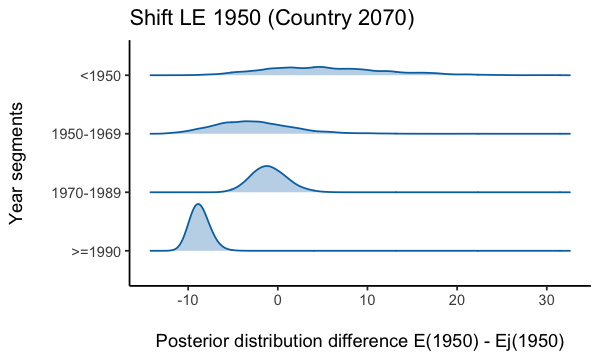

In [171]:
p = ggplot(d, aes(y=variable)) +
      geom_density_ridges(aes(x = value),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1950) - Ej(1950)', 
          y='Year segments\n', title='Shift LE 1950 (Country 2070)') + 
      theme_classic()
print(p)

# Create all shifts (country and years)

In [109]:
estimate_shift = function(samples, country=NULL, 
                          model_year=NULL,
                          le_value=NULL,
                          gdp_value = NULL, 
                          max_le_value = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))
    s = samples[, c(betas, random)]
    pp = s[,1] + s[,3] + (s[,2] + s[,4]) * gdp_value
    pg = unlist(sapply(pp, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
        
     return(le_value-pg)
}

In [58]:
countries = unique(df$ctry)
iyears = c(1950, 1970, 1990, 2010)
model_year = c('1950', '1950-1969', '1970-1989', '1990')

In [149]:
shifts = list()

for (c in countries) {
        
    max_le_value = max_le[ctry==c, max_le]
    years = as.numeric(df[ctry == c & year %in% iyears, year])
    model_years = as.character(unique(df[ctry == c, gyear]))

    for (ys in years) {
        
        for (ysm in model_years) { 
            
            est = estimate_shift(samples, 
                                 country = c, 
                                 model_year = ysm, 
                                 gdp_value = df[ctry==c & year==ys, gdp_log],
                                 le_value =  df[ctry==c & year==ys, le],
                                 max_le_value=max_le_value)
            name = paste0(c(c,ys,ysm), collapse='.')
            shifts[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_shift = est)
                                     
          }
    
    }
    
}

In [161]:
shifts = rbindlist(shifts)

shifts[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

shifts[, segment := factor(segment, levels=c('1990', '1970-1989', '1950-1969', '1950'), 
                         labels = c('>=1990', '1970-1989', '1950-1969', '<1950')) ]

In [166]:
options(repr.plot.width = 5, repr.plot.height = 3)

Picking joint bandwidth of 0.401


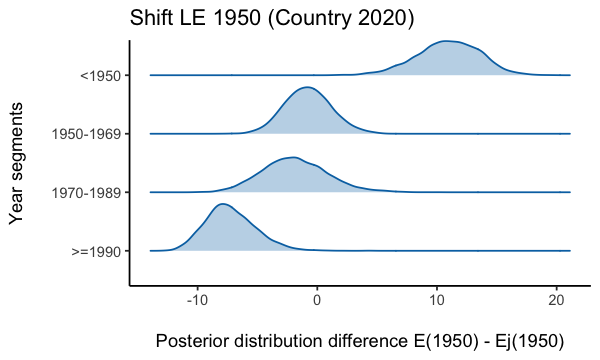

In [170]:
p = ggplot(shifts[year=='1950' & ctry=='2020', ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1950) - Ej(1950)', 
          y='Year segments\n', title='Shift LE 1950 (Country 2020)') + 
      theme_classic()
print(p)

Picking joint bandwidth of 0.37


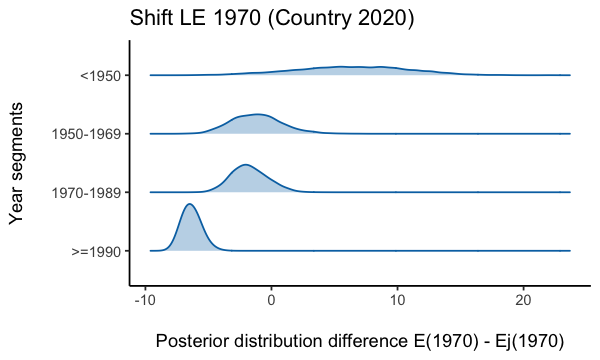

In [169]:
p = ggplot(shifts[year=='1970' & ctry=='2020', ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1970) - Ej(1970)', 
          y='Year segments\n', title='Shift LE 1970 (Country 2020)') + 
      theme_classic()
print(p)

Picking joint bandwidth of 0.367


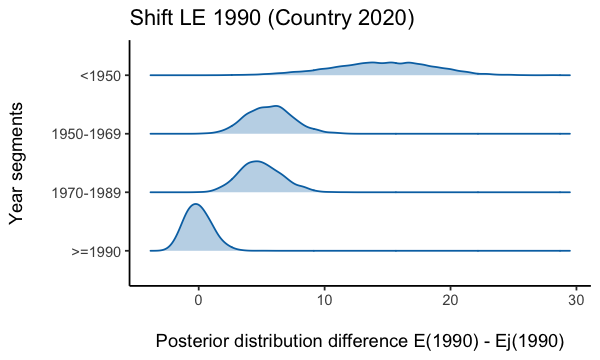

In [167]:
p = ggplot(shifts[year=='1990' & ctry=='2020', ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1990) - Ej(1990)', 
          y='Year segments\n', title='Shift LE 1990 (Country 2020)') + 
      theme_classic()
print(p)